In [1]:
import re
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unicodecsv as csv

# Analysize variables.

In [2]:
# Read documentation.
columns_file = r"../records_documentation.txt"

with open(columns_file,"r") as f:
    columns = f.readlines()
columns
        

['[Column 0] ID\n',
 '[Column 1] Birth year: deduced from education history, where available\n',
 '[Column 2] Gender flag: 1=female, 2=male, 0=unknown\n',
 '[Column 3] Skillset1: primary skillset deduced from self-reported skills\n',
 '[Column 4] Skillset1 weight: the extent to which primary skillset is representative of overall self-reported skills\n',
 '[Column 5] Skillset2: secondary skillset deduced from self-reported skills\n',
 '[Column 6] Skillset2 weight: the extent to which secondary skillset is representative of overall self-reported skills\n',
 '[Column 7] City of profile (does not change): where unavailable, the field is left blank\n',
 '[Column 8] Country of Profile (does not change)\n',
 '[Column 9] Education (highest degree attained): 0=none/unknown; 1=high school; 2=vocational degree; 3=associateÕs; 4=bachelorÕs; 5=masterÕs other than MBA; 6=MBA; 7=doctorate (PhD/JD/MD) [NB: Romanian names not covered]\n',
 "[Column 10] Elite institution: a flag indicating whether any o

So:
- Unique identifier: ID.
- Variable Groups:
    - Column 0-10, profile info; 
    - Column 11-28, employment or education info; (c26 = False or True)
        - Column 11-18, general info;
        - Column 19-25, company info;
        - Column 27-28, school info.

In [3]:
# Get unique values for each variable.
empl_file = r"../deloitte_pwc.csv"

unique_values = []
for i in range(33):
    unique_values.append(set())
with open(empl_file,"rb") as f:
    reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
    for idx, line in enumerate(reader):
        for i in range(33):
            unique_values[i].add(line[i])
for idx, values in enumerate(unique_values):
    print("[Column {}] ".format(idx)+str(len(values)))
        

[Column 0] 1095185
[Column 1] 84
[Column 2] 3
[Column 3] 45
[Column 4] 390501
[Column 5] 45
[Column 6] 390503
[Column 7] 16127
[Column 8] 258
[Column 9] 8
[Column 10] 2
[Column 11] 849
[Column 12] 3
[Column 13] 763
[Column 14] 3
[Column 15] 2
[Column 16] 3246
[Column 17] 2640332
[Column 18] 865
[Column 19] 1767657
[Column 20] 1557541
[Column 21] 10261
[Column 22] 309
[Column 23] 2
[Column 24] 204454
[Column 25] 739
[Column 26] 2
[Column 27] 8
[Column 28] 2
[Column 29] 1469
[Column 30] 68
[Column 31] 7835
[Column 32] 1003970


In [4]:
# One block to convert data to pd.DataFrame.
empl_file = r"../deloitte_pwc.csv"

entries_lst = []
with open(empl_file,"rb") as f:
    reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
    for idx, line in enumerate(reader):
        if idx == 5: # Control number of rows.
            break
        entries_lst.append(line)

samples_lst = entries_lst
entries_df = pd.DataFrame(data=entries_lst)
entries_df


,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,ed3c50a8-d2d3-3809-9d2a-0f53574560aa,1980,2,Accounting and Auditing,0.9292892909340925,Industrial Management,0.00825650305491638,Paris,France,5,...,False,,,True,5,False,,,,1525765406000
1,ed3c50a8-d2d3-3809-9d2a-0f53574560aa,1980,2,Accounting and Auditing,0.9292892909340925,Industrial Management,0.00825650305491638,Paris,France,5,...,False,,,True,,False,,,,1525765406000
2,ed3c50a8-d2d3-3809-9d2a-0f53574560aa,1980,2,Accounting and Auditing,0.9292892909340925,Industrial Management,0.00825650305491638,Paris,France,5,...,False,,,False,,False,,,,1525765406000
3,ed3c50a8-d2d3-3809-9d2a-0f53574560aa,1980,2,Accounting and Auditing,0.9292892909340925,Industrial Management,0.00825650305491638,Paris,France,5,...,False,,54,False,,False,,,,1525765406000
4,ed3c50a8-d2d3-3809-9d2a-0f53574560aa,1980,2,Accounting and Auditing,0.9292892909340925,Industrial Management,0.00825650305491638,Paris,France,5,...,False,"paris area, france",54,False,,False,,,,1525765406000


In [5]:
# Get an example.
entry = samples_lst[1]
for i in range(len(entry)):
    print("[Column {}] ".format(i)+entry[i])

[Column 0] ed3c50a8-d2d3-3809-9d2a-0f53574560aa
[Column 1] 1980
[Column 2] 2
[Column 3] Accounting and Auditing
[Column 4] 0.9292892909340925
[Column 5] Industrial Management
[Column 6] 0.00825650305491638
[Column 7] Paris
[Column 8] France
[Column 9] 5
[Column 10] False
[Column 11] 2004-01-01
[Column 12] False
[Column 13] 2004-01-01
[Column 14] False
[Column 15] False
[Column 16] 0
[Column 17] 
[Column 18] 
[Column 19] Vaasan yliopisto
[Column 20] Vaasan yliopisto
[Column 21] 
[Column 22] 
[Column 23] False
[Column 24] 
[Column 25] 
[Column 26] True
[Column 27] 
[Column 28] False
[Column 29] 
[Column 30] 
[Column 31] 
[Column 32] 1525765406000


# Aggregate hiring/firing to the firm-by-date level.

In [6]:
# Read, Identify & Aggregate. - A code to output raw data for reference. Unfinished and unused.
empl_file = r"../deloitte_pwc.csv"

## Initialize.
career_lst = [] # Will contain the entries for the same person.
person_this = None
profile_this = None

## Iterate.
empl_changes_lst = []
with open(empl_file,"rb") as f:
    reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
    for idx, entry in enumerate(itertools.chain(reader,[None]*33)):
        if idx == 100: # End point.
            break
        if person_this != entry[0]:
            if career_lst != []:
                ### Analyze.
                career_df = pd.DataFrame(career_lst)
                print(career_df[[0,1,2,3,4,10,14]])
                print(profile_this)
                ####################################################################
                # empl_changes_lst.append()
            ### Re-initialize.
            person_this = entry[0]
            profile_this = entry[1:11]
            career_lst = []
        ### Record this entry.
        if profile_this[2] == 'Accounting and Auditing' and entry[26] == 'False': # only consider accountants.
            career_lst.append(entry[11:29])

#####################################################
# empl_changes_df = pd.DataFrame(empl_changes_lst)
            

           0      1           2      3      4  10  14
0  2004-09-01   True  2005-06-01   True  False       
1  2006-07-01   True  2006-11-01   True  False  P  54
2  2007-01-01   True  2012-10-01   True  False  P  54
3  2012-10-01   True  2016-07-01   True  False     48
4  2017-01-01  False        None  False   True     92
['1980', '2', 'Accounting and Auditing', '0.9292892909340925', 'Industrial Management', '0.00825650305491638', 'Paris', 'France', '5', 'False']
           0      1           2      3      4         10        14
0  2001-01-01  False  2001-12-01  False  False  TIME_OFF  TIME_OFF
1  2002-09-01   True  2003-02-01   True  False         D       561
2  2003-02-01   True  2004-07-01   True  False         D       561
3  2004-09-01   True  2005-02-01   True  False         D       561
4  2005-09-01   True  2008-09-01   True  False         D       561
5  2008-08-01   True  2013-07-01   True  False         D       561
6  2013-07-01   True  2016-11-01   True  False                 

In [7]:
# Define a class to read and process entries.
class entryProcessor:    
    
    def __init__(self, person_id):
        self.person_id = person_id
        self.profile = [None]*6 # "birth_year","gender","secondary_skill","country","education_level","f_elite"
        self.employment = [None]*4 # "start_date","end_date","ticker","f_current"
        
    # Two functions to output records.
    # Varlist: Hiring/Firing, Ticker, year-month, profile_info: [...], next_industry.
    def enter_record(self):
        return ['hiring',self.employment[2],self.employment[0]]+self.profile+['']    
    def leave_record(self,next_industry):
        return ['firing',self.employment[2],self.employment[1]]+self.profile+[next_industry]   
    
    # When id changes, record a possible leave and then clear contents.
    def reinitialize(self,entry):
        if self.employment[3]=="False":
            record = self.leave_record('')
        else:
            record = None
        self.__init__(entry[0])
        self.profile = [entry[x] for x in [1,2,5,8,9,10]]
        return record
    
    # Main method: read and process.
    def read(self,entry):
        record = []
        # Reinitialize when id changes.
        if self.person_id != entry[0]:
            leave_last = self.reinitialize(entry)
            if leave_last is not None:
                record.append(leave_last)
        # Then deal with the current entry.
        if entry[3]=="Accounting and Auditing" and entry[26] == "False":
            if self.employment[2] != entry[21]:
                if self.employment[2] in ['D','P']:
                    record.append(self.leave_record(entry[25]))
                self.employment = [None]*4
                if entry[21] in ['D','P']:
                    self.employment[0] = entryProcessor.convert_time(entry[11],entry[12])
                    self.employment[1] = entryProcessor.convert_time(entry[13],entry[14])
                    self.employment[2] = entry[21]
                    self.employment[3] = entry[15]
                    record.append(self.enter_record())
            else:
                self.employment[1] = entryProcessor.convert_time(entry[13],entry[14])
                self.employment[3] = entry[15]
        return record
            
    # Unbound methods.
    def convert_time(date,f_valid_month):
        date_regex = re.match(r"(\d{4})-(\d{2})-\d{2}",date)
        if date_regex is None:
            return None
            #raise ValueError('Not a proper date: {}'.format(date))
        else:
            return date_regex.group(1)+('00' if f_valid_month == 'False' else date_regex.group(2))
        
    # For print.
    def __str__(self):
        return "[person_id: {}, profile: {}, employment: {}]".format(self.person_id, self.profile, self.employment)
            
#entry = entryProcessor(None)
#for i in range(50):
#    print(i)
#    print(entry.read(samples_lst[i]))
#    print(entry)

In [8]:
# Read, Identify & Aggregate.
empl_file = r"../deloitte_pwc.csv"

## Initialize.
career = entryProcessor(None)

## Iterate.
empl_changes_lst = []
with open(empl_file,"rb") as f:
    reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
    for idx, entry in enumerate(itertools.chain(reader,[[None]*33])):
        if idx == np.inf: # End point.
            break
        empl_change_this = career.read(entry)
        if empl_change_this != []:
            empl_changes_lst += empl_change_this

varlist = ["type","ticker","yrmth","birth","gender","skill2","cntry","edu","f_elite","ind_next"]
empl_changes_df = pd.DataFrame(data=empl_changes_lst,columns=varlist)
empl_changes_df


,type,ticker,yrmth,birth,gender,skill2,cntry,edu,f_elite,ind_next
0,hiring,P,200607,1980,2,Industrial Management,France,5,False,
1,firing,P,201210,1980,2,Industrial Management,France,5,False,48
2,hiring,D,200209,1978,2,Personal Coaching,Netherlands,2,False,
3,firing,D,201307,1978,2,Personal Coaching,Netherlands,2,False,
4,hiring,D,200708,1983,2,Technical Product Management,Ukraine,4,False,
5,firing,D,200808,1983,2,Technical Product Management,Ukraine,4,False,
6,hiring,P,201108,1986,2,Administration,Saudi Arabia,6,False,
7,hiring,P,201405,1985,1,Musical Production,Singapore,4,False,
8,firing,P,201407,1985,1,Musical Production,Singapore,4,False,54
9,hiring,P,201207,1988,0,Business Development,New Zealand,4,False,


# Summarize and plot.

In [58]:
# Styles for the four groups: ('ticker': 'D','P') x ('firing', 'hiring')
line_styles = ['b^-','bo-','r^-','ro-']
color_styles = ['dodgerblue','b','salmon','r']

# Styles for the two tickers: ('D', 'P')
color_styles_2 = ['b','r']

In [91]:
# Deal with 'yrmth'.
empl_changes_df = empl_changes_df.assign(
    year = lambda df:df.yrmth.apply(lambda x:int(x[:4]) if x is not None else np.nan),
    month = lambda df:df.yrmth.apply(lambda x:int(x[4:]) if x is not None else -1)
)


empl_changes_df.describe(include=[np.object])

,type,ticker,yrmth,birth,gender,skill2,cntry,edu,f_elite,ind_next
count,253749,253749,247615,253749,253749,253749,253749,253749,253749,253749
unique,2,2,683,84,3,43,219,8,2,539
top,hiring,P,201109,2000,2,Banking and Finance,United States,4,False,
freq,143739,136539,2996,26907,111968,66975,64295,125613,243230,183025


## Overall trends.
Note: Plots by year and plots by months do not only differ in frequency, but also in sample size. This is due to the entries without valid month record.

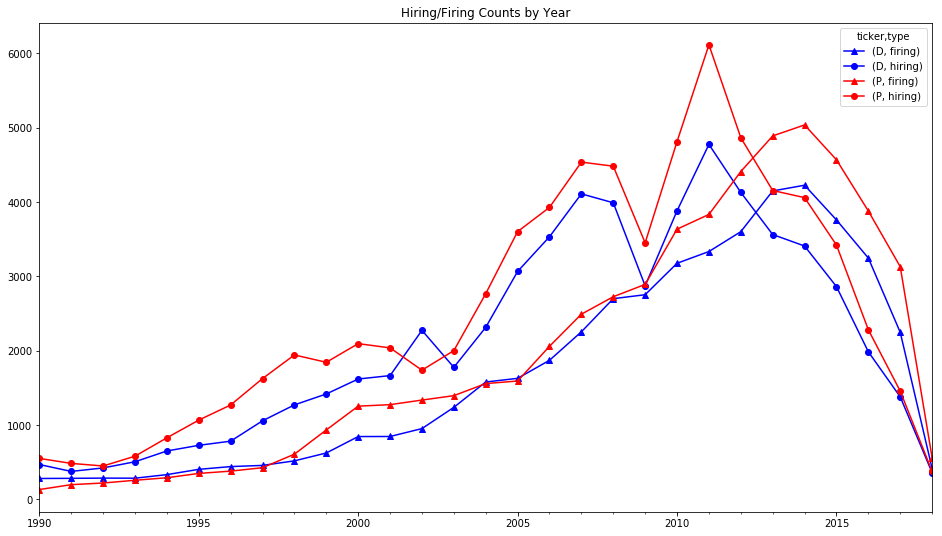

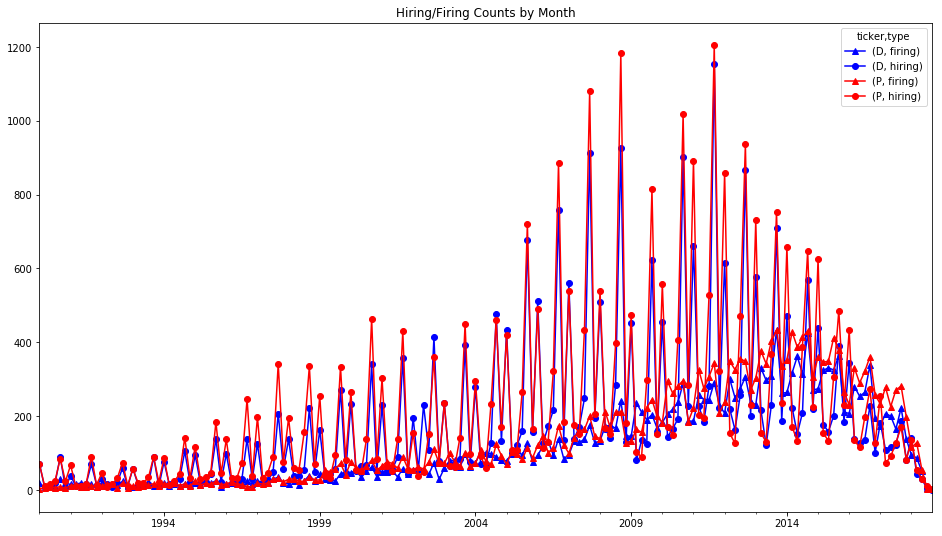

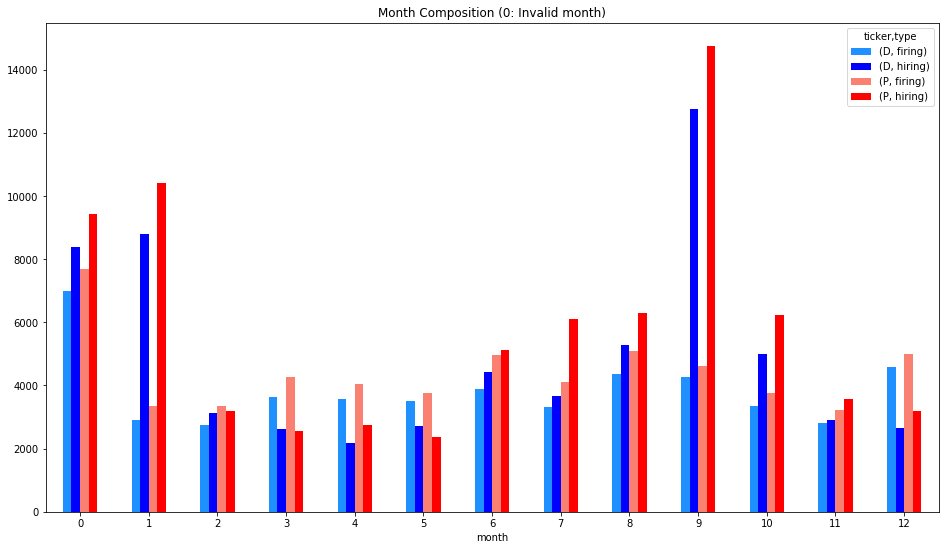

In [136]:
count_by_months = pd.DataFrame({'count':empl_changes_df.groupby(['ticker','type','year','month']).size()}).reset_index()

# Plot by year.
to_plot = count_by_months[['ticker','type','year','count']]
to_plot = to_plot.loc[to_plot.year>=1990]
to_plot = to_plot.pivot_table(
    index=pd.PeriodIndex(year=to_plot.year,month=0,freq='A'),
    columns=['ticker','type'],values='count',aggfunc='sum')
to_plot.plot(figsize=(16,9),style=line_styles,title="Hiring/Firing Counts by Year")
plt.show()

# Plot by month.
to_plot = count_by_months[['ticker','type','year','month','count']]
to_plot = to_plot.loc[(to_plot.year>=1990) & (to_plot.month)]
to_plot = to_plot.pivot_table(
    index=pd.PeriodIndex(year=to_plot.year,month=to_plot.month,freq='M'),
    columns=['ticker','type'],values='count',aggfunc='sum')
to_plot.plot(figsize=(16,9),style=line_styles,title="Hiring/Firing Counts by Month")
plt.show()

# Month composition.
to_plot = count_by_months.pivot_table(
    index='month',columns=['ticker','type'],values='count',aggfunc='sum')
to_plot.plot.bar(figsize=(16,9),color=color_styles,rot=0,title="Month Composition (0: Invalid month)")
plt.show()

## By birth group.
Note: Birth year `2000` seems to be a trash bin for problematic records and thus will be treated the same as `None`.

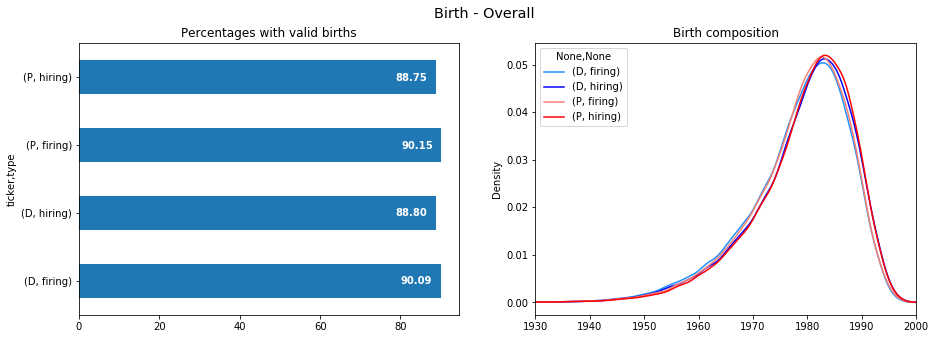

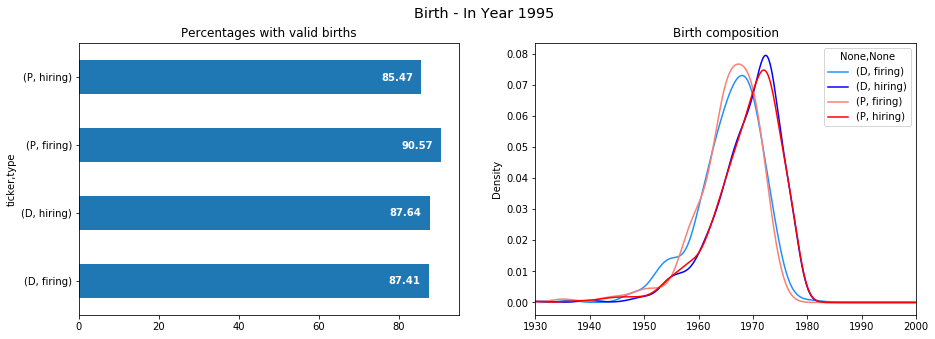

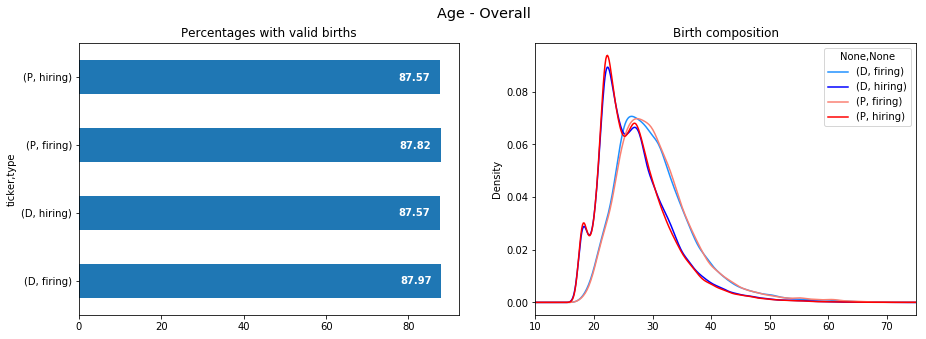

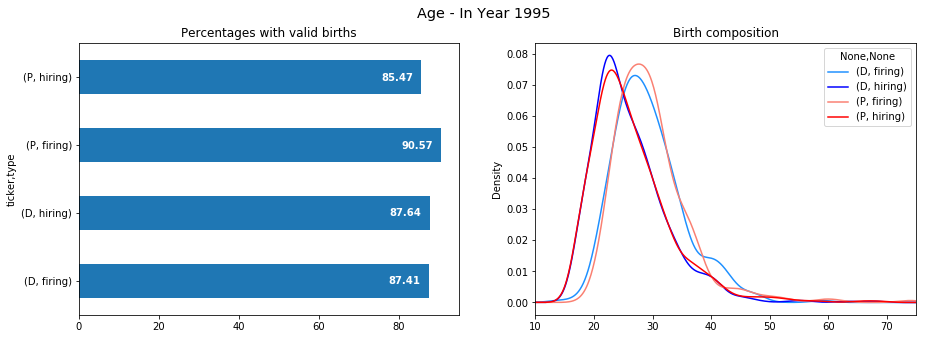

In [135]:
birth_df = empl_changes_df[['ticker','type','year','birth']]
birth_df = birth_df.assign(
    birth = lambda df:df.birth.apply(lambda x:int(x) if x not in ['2000','None'] else np.nan),
    age = lambda df:(df.year-df.birth)
)

# Define a routine to generate plots.
def birth_plot(DF,var,title,xlim=None):
    plt.subplots(1,2,figsize=(15,5))
    plt.suptitle(title,fontsize="x-large")
    plt.subplot(121)
    to_plot = DF.groupby(['ticker','type']).apply(lambda df:(df.loc[~df[var].isnull()].size/df.size*100))
    ax = to_plot.plot.barh(title="Percentages with valid births")
    for idx, value in enumerate(to_plot):
        ax.text(value-10,idx-0.05,'{:.2f}'.format(value),color='white',fontweight='bold')
    plt.subplot(122)
    for (idx, group), color in zip(DF.loc[~DF[var].isnull()].groupby(['ticker','type']),color_styles):
        group[var].plot.kde(xlim=xlim,label=idx,title="Birth composition",color=color,legend=True)
    plt.show()
    
birth_plot(birth_df,'birth',"Birth - Overall",(1930,2000))
birth_plot(birth_df.loc[birth_df.year==1995],'birth',"Birth - In Year 1995",(1930,2000))
birth_plot(birth_df,'age',"Age - Overall",(10,75))
birth_plot(birth_df.loc[birth_df.year==1995],'age',"Age - In Year 1995",(10,75))

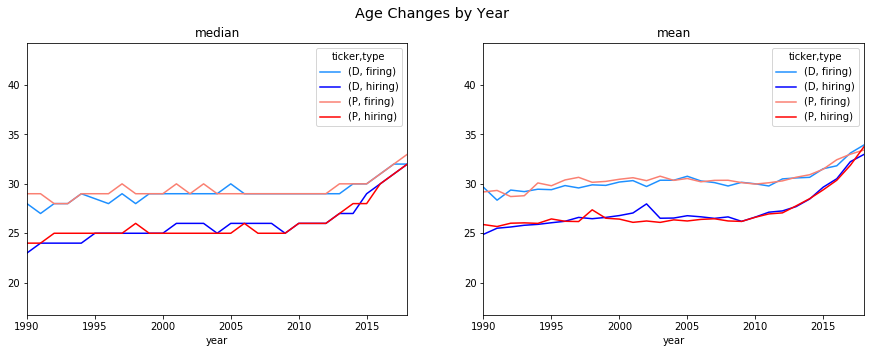

In [158]:
# Age changes by year.
fig, (ax1, ax2)=plt.subplots(1,2,figsize=(15,5))
birth_df.pivot_table(
    index='year',columns=['ticker','type'],values='age',aggfunc='median'
).plot(xlim=(1990,2018),color=color_styles,ax=ax1,title='median')
birth_df.pivot_table(
    index='year',columns=['ticker','type'],values='age',aggfunc='mean'
).plot(xlim=(1990,2018),color=color_styles,ax=ax2,title='mean')
fig.suptitle('Age Changes by Year',fontsize='x-large')
plt.show()

## By Gender.

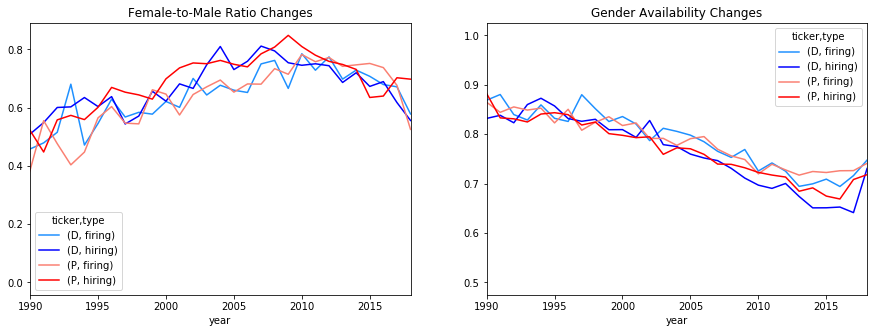

In [178]:
fig, (ax1, ax2)=plt.subplots(1,2,figsize=(15,5))
empl_changes_df.pivot_table(
    index='year',columns=['ticker','type'],values='gender',
    aggfunc=lambda x:((x=='1').sum()/(x=='2').sum() if (x=='2').sum() else np.nan)
).plot(xlim=(1990,2018),color=color_styles,title="Female-to-Male Ratio Changes",ax=ax1)
empl_changes_df.pivot_table(
    index='year',columns=['ticker','type'],values='gender',
    aggfunc=lambda x:((x!='0').sum()/x.size)
).plot(xlim=(1990,2018),color=color_styles,title="Gender Availability Changes",ax=ax2)
plt.show()

## By Secondary Skill.

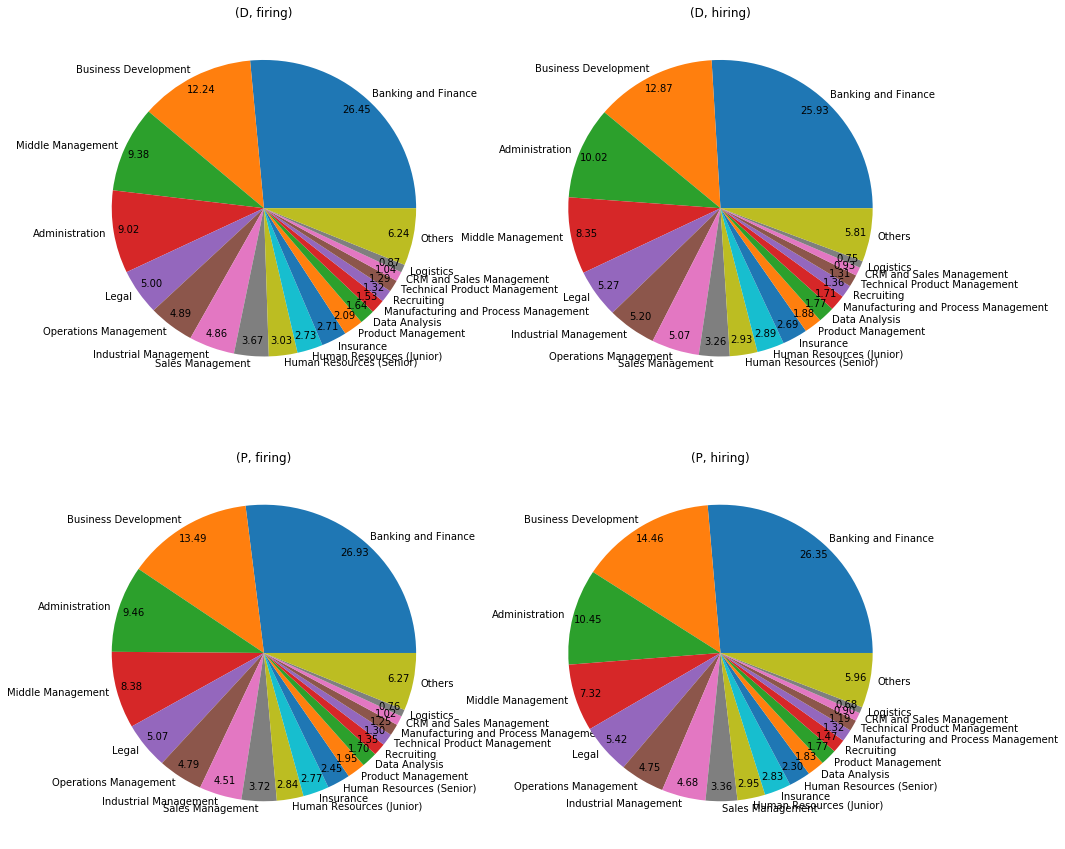

In [246]:
fig,axs=plt.subplots(2,2,figsize=(15,15))
for (idx,col),ax in zip(empl_changes_df.pivot_table(
    index='skill2',columns=['ticker','type'],values='gender',aggfunc='count'
).iteritems(),itertools.chain.from_iterable(axs)):
    to_plot0 = col.sort_values(ascending=False)
    to_plot = to_plot0.iloc[0:18]
    to_plot.loc['Others']=to_plot0.sum()-to_plot.sum()  
    to_plot.plot.pie(ax=ax,labeldistance=1.05,title=str(idx).replace("'",''),autopct='%.2f',pctdistance=0.9)
    ax.set_ylabel('')
plt.show()

## By Country.

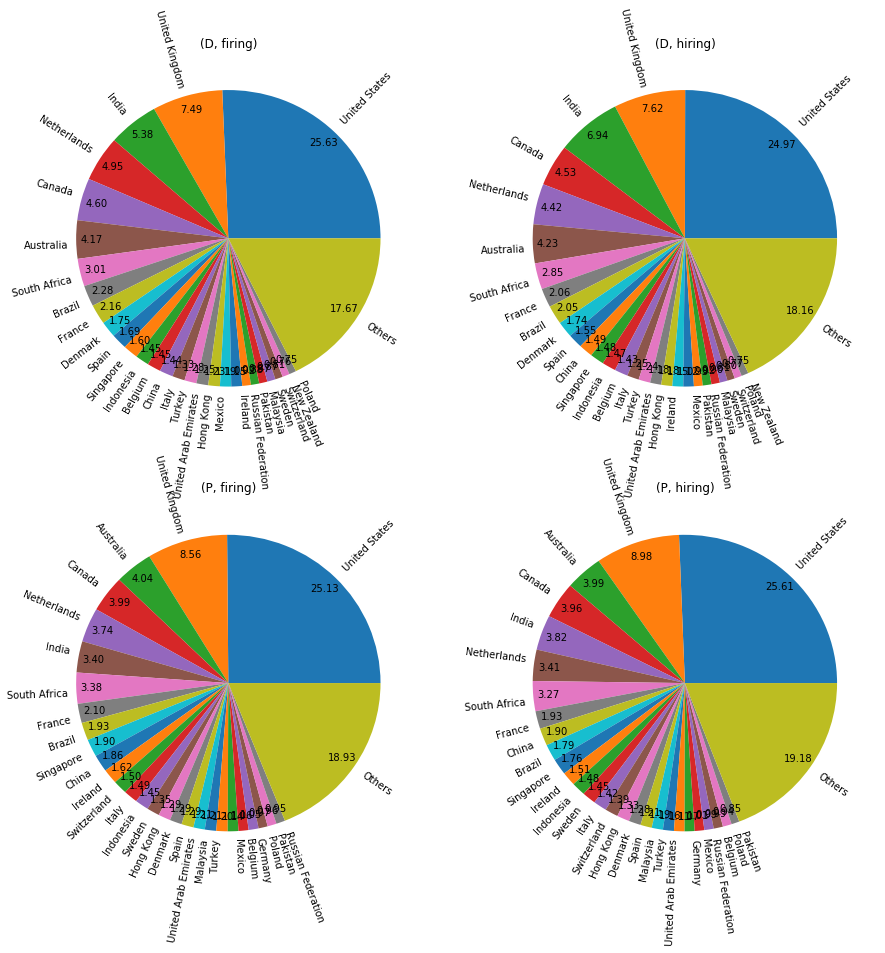

In [251]:
fig,axs=plt.subplots(2,2,figsize=(15,15))
for (idx,col),ax in zip(empl_changes_df.pivot_table(
    index='cntry',columns=['ticker','type'],values='gender',aggfunc='count'
).iteritems(),itertools.chain.from_iterable(axs)):
    to_plot0 = col.sort_values(ascending=False)
    to_plot = to_plot0.iloc[0:28]
    to_plot.loc['Others']=to_plot0.sum()-to_plot.sum()  
    to_plot.plot.pie(ax=ax,labeldistance=1.05,title=str(idx).replace("'",''),autopct='%.2f',pctdistance=0.9,rotatelabels=True)
    ax.set_ylabel('')
plt.show()